# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [68]:
#!pip -q install vit_pytorch linformer

## Import Libraries

In [1]:
# from __future__ import print_function

import glob
# from itertools import chain
import os
import random
# import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
#from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import torchvision
from vit_pytorch.efficient import ViT


In [2]:
print(f"Torch: {torch.__version__}")

Torch: 2.2.2+cpu


In [3]:
# Training settings
batch_size = 64
epochs = 20 #20
lr = 3e-5
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Data

In [74]:
#os.makedirs('data', exist_ok=True)

In [6]:
train_dir = 'd:/dataset/cats-dogs/train'
test_dir = 'd:/dataset/cats-dogs/test'

In [76]:
# with zipfile.ZipFile('train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('test.zip') as test_zip:
#     test_zip.extractall('data')

In [7]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [8]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [9]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

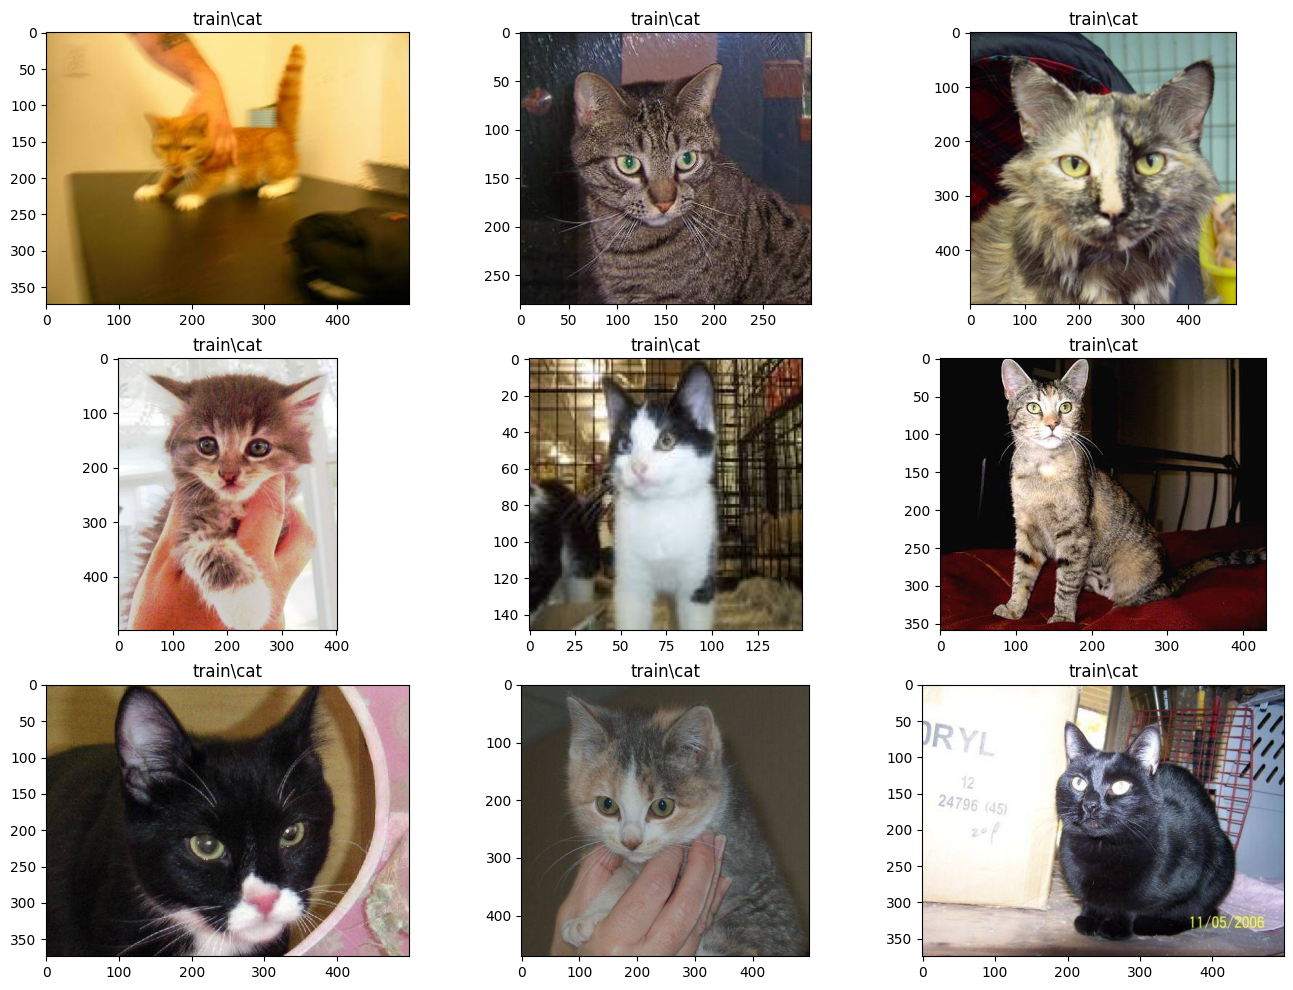

In [10]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


In [11]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


## Image Augmentation

In [12]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Split

In [13]:
# 定义训练集和验证集的比例
train_data = CatsDogsDataset(train_list, transform=train_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)
train_size = int(0.8 * len(train_list))
val_size = len(train_list) - train_size

# 使用 random_split 方法将数据集分割为训练集和验证集
train_data, valid_data = random_split(train_data, [train_size, val_size])

In [14]:
print(f"Train Data: {len(train_data)}")
print(f"Validation Data: {len(valid_data)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [15]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [16]:
print(len(train_data), len(train_loader))

20000 313


In [17]:
print(len(valid_data), len(valid_loader))

5000 79


## Efficient Attention

### Linformer

In [18]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [19]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [20]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [21]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0248 - acc: 0.9872 - val_loss : 0.0008 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0005 - acc: 1.0000 - val_loss : 0.0003 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.0002 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0002 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0001 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0001 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0000 - acc: 1.0000 - val_loss : 0.0000 - val_acc: 1.0000



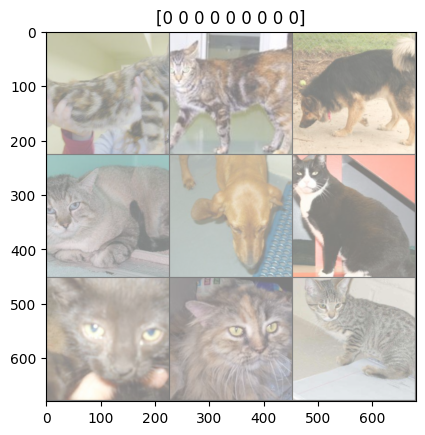

In [93]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp * 0.5 + 0.5
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        lables =torch.argmax(model(data),-1).numpy()
        break

out = torchvision.utils.make_grid(data[:9],nrow=3)

imshow(out, title=lables[:9])
    
